In [64]:
import pandas as pd

df = pd.read_csv("data/Microsoft_Stock.csv", parse_dates=["Date"])

df['Date'] = df['Date'].dt.date # Extract only the date part
df['Volume'] = df['Volume'].astype(float)

df.drop_duplicates(inplace=True)
df = df.sort_values("Date").set_index("Date")
df.index = pd.to_datetime(df.index)

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01,40.60,40.76,40.31,40.72,36865322.0
2015-04-02,40.66,40.74,40.12,40.29,37487476.0
2015-04-06,40.34,41.78,40.18,41.55,39223692.0
2015-04-07,41.61,41.91,41.31,41.53,28809375.0
2015-04-08,41.48,41.69,41.04,41.42,24753438.0


#### Naive Forecating

In [6]:
diff_7 = df['Volume'].diff(7)["2015-04":]
naive_mae = diff_7.abs().mean()
print(f"Naive Forecast MAE = {naive_mae}")

Naive Forecast MAE = 11078096.830452127


#### The ARMA Model Family: SARIMA

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [54]:
origin, start_date, end_date = "2016-01-01", "2016-04-01", "2021-03-31"
time_period = pd.date_range(start_date, end_date)

volume_series = df.loc[origin:end_date]["Volume"].asfreq("D")
y_preds = []

In [55]:
for today in time_period.shift(-1):
    model = ARIMA(volume_series[origin:today], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
sarima_mae = (y_preds - volume_series[time_period]).abs().mean()
print(f"SARIMA Forecast MAE = {sarima_mae}")

SARIMA Forecast MAE = 6909895.069312916


#### Linear Model

In [69]:
volume_train = df["Volume"][:"2019-12"]/1e6
volume_valid = df["Volume"]["2020-01":"2020-08"]/1e6
volume_test = df["Volume"]["2020-09":"2021-03"]/1e6

In [72]:
import numpy as np
import tensorflow as tf

seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    volume_train.to_numpy(),
    targets=volume_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    volume_valid.to_numpy(),
    targets=volume_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [73]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [77]:
tf.random.set_seed(42)
lin_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

linear_mae = fit_and_evaluate(lin_model, train_ds, valid_ds, learning_rate=0.01)
print(f"Linear Model Forecast MAE = {linear_mae}")

Epoch 1/500
36/36 [==============================] - 1s 9ms/step - loss: 247.4206 - mae: 247.9202 - val_loss: 367.3449 - val_mae: 367.8449
Epoch 2/500
36/36 [==============================] - 0s 5ms/step - loss: 208.7112 - mae: 209.2112 - val_loss: 543.7933 - val_mae: 544.2933
Epoch 3/500
36/36 [==============================] - 0s 5ms/step - loss: 392.7336 - mae: 393.2335 - val_loss: 832.2133 - val_mae: 832.7133
Epoch 4/500
36/36 [==============================] - 0s 5ms/step - loss: 484.6264 - mae: 485.1262 - val_loss: 767.6802 - val_mae: 768.1802
Epoch 5/500
36/36 [==============================] - 0s 5ms/step - loss: 279.5536 - mae: 280.0536 - val_loss: 320.4626 - val_mae: 320.9626
Epoch 6/500
36/36 [==============================] - 0s 5ms/step - loss: 170.3143 - mae: 170.8143 - val_loss: 220.1760 - val_mae: 220.6760
Epoch 7/500
36/36 [==============================] - 0s 5ms/step - loss: 206.9194 - mae: 207.4188 - val_loss: 671.0414 - val_mae: 671.5414
Epoch 8/500
36/36 [========

36/36 [==============================] - 0s 5ms/step - loss: 309.1724 - mae: 309.6722 - val_loss: 793.2524 - val_mae: 793.7524
Epoch 60/500
36/36 [==============================] - 0s 4ms/step - loss: 340.9221 - mae: 341.4221 - val_loss: 443.3049 - val_mae: 443.8049
Epoch 61/500
36/36 [==============================] - 0s 5ms/step - loss: 164.8972 - mae: 165.3955 - val_loss: 96.6223 - val_mae: 97.1223
Epoch 62/500
36/36 [==============================] - 0s 5ms/step - loss: 374.5682 - mae: 375.0677 - val_loss: 645.6813 - val_mae: 646.1813
Epoch 63/500
36/36 [==============================] - 0s 4ms/step - loss: 251.9788 - mae: 252.4782 - val_loss: 544.4774 - val_mae: 544.9774
Epoch 64/500
36/36 [==============================] - 0s 4ms/step - loss: 284.8122 - mae: 285.3121 - val_loss: 961.6253 - val_mae: 962.1253
Epoch 65/500
36/36 [==============================] - 0s 4ms/step - loss: 442.3506 - mae: 442.8506 - val_loss: 615.9493 - val_mae: 616.4493
Epoch 66/500
36/36 [===============

#### Simple RNN

In [78]:
tf.random.set_seed(42)
simple_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None,1])
])
simple_rnn_mae = fit_and_evaluate(simple_rnn_model, train_ds, valid_ds, learning_rate=0.01)
print(f"Simple RNN Model Forecast MAE = {simple_rnn_mae}")

Epoch 1/500
36/36 [==============================] - 2s 17ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 2/500
36/36 [==============================] - 0s 9ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 3/500
36/36 [==============================] - 0s 10ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 4/500
36/36 [==============================] - 0s 11ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 5/500
36/36 [==============================] - 0s 11ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 6/500
36/36 [==============================] - 0s 11ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 7/500
36/36 [==============================] - 0s 11ms/step - loss: 28.7940 - mae: 29.2940 - val_loss: 39.0985 - val_mae: 39.5985
Epoch 8/500
36/36 [==============================

#### Deep RNN

In [79]:
tf.random.set_seed(42)

deep_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

deep_rnn_mae = fit_and_evaluate(deep_rnn_model, train_ds, valid_ds, learning_rate=0.01)
print(f"Deep RNN Model Forecast MAE = {deep_rnn_mae}")

Epoch 1/500
36/36 [==============================] - 4s 42ms/step - loss: 13.9459 - mae: 14.4379 - val_loss: 12.7977 - val_mae: 13.2864
Epoch 2/500
36/36 [==============================] - 1s 30ms/step - loss: 8.0544 - mae: 8.5385 - val_loss: 13.8750 - val_mae: 14.3718
Epoch 3/500
36/36 [==============================] - 1s 31ms/step - loss: 8.0046 - mae: 8.4907 - val_loss: 13.3505 - val_mae: 13.8412
Epoch 4/500
36/36 [==============================] - 1s 30ms/step - loss: 8.0086 - mae: 8.4954 - val_loss: 13.7858 - val_mae: 14.2812
Epoch 5/500
36/36 [==============================] - 1s 31ms/step - loss: 7.9865 - mae: 8.4667 - val_loss: 13.6674 - val_mae: 14.1605
Epoch 6/500
36/36 [==============================] - 1s 32ms/step - loss: 7.9962 - mae: 8.4803 - val_loss: 13.5003 - val_mae: 13.9927
Epoch 7/500
36/36 [==============================] - 1s 32ms/step - loss: 8.0552 - mae: 8.5400 - val_loss: 14.1187 - val_mae: 14.6178
Epoch 8/500
36/36 [==============================] - 1s 33ms

Epoch 62/500
36/36 [==============================] - 1s 31ms/step - loss: 8.1275 - mae: 8.6126 - val_loss: 13.9386 - val_mae: 14.4362
Epoch 63/500
36/36 [==============================] - 1s 36ms/step - loss: 7.9980 - mae: 8.4835 - val_loss: 14.1350 - val_mae: 14.6342
Epoch 64/500
4/4 [==============================] - 0s 8ms/step - loss: 11.5968 - mae: 12.0818
Deep RNN Model Forecast MAE = 12081774.711608887


#### Sequence to Sequence Model

In [81]:
def to_windows(dataset, window_size):
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    return dataset

In [84]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, :-ahead], S[:, -ahead:]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [85]:
seq2seq_train = to_seq2seq_dataset(volume_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(volume_valid)

In [89]:
tf.random.set_seed(42)

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(14)
])

seq2seq_mae = fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.01)
print(f"Sequence to Sequence Model Forecast MAE = {seq2seq_mae}")

Epoch 1/500
36/36 [==============================] - 2s 23ms/step - loss: 25.5894 - mae: 26.0894 - val_loss: 38.3677 - val_mae: 38.8677
Epoch 2/500
36/36 [==============================] - 1s 16ms/step - loss: 17.7970 - mae: 18.2952 - val_loss: 30.0377 - val_mae: 30.5376
Epoch 3/500
36/36 [==============================] - 1s 19ms/step - loss: 10.9214 - mae: 11.4093 - val_loss: 23.4980 - val_mae: 23.9953
Epoch 4/500
36/36 [==============================] - 1s 17ms/step - loss: 8.4336 - mae: 8.9154 - val_loss: 20.8730 - val_mae: 21.3716
Epoch 5/500
36/36 [==============================] - 1s 17ms/step - loss: 8.0761 - mae: 8.5618 - val_loss: 20.0908 - val_mae: 20.5879
Epoch 6/500
36/36 [==============================] - 1s 16ms/step - loss: 8.0259 - mae: 8.5134 - val_loss: 19.8648 - val_mae: 20.3616
Epoch 7/500
36/36 [==============================] - 1s 16ms/step - loss: 8.0181 - mae: 8.5054 - val_loss: 19.7425 - val_mae: 20.2392
Epoch 8/500
36/36 [==============================] - 1s 

Epoch 62/500
36/36 [==============================] - 1s 15ms/step - loss: 8.0188 - mae: 8.5055 - val_loss: 19.6419 - val_mae: 20.1383
Epoch 63/500
36/36 [==============================] - 1s 15ms/step - loss: 8.0155 - mae: 8.5023 - val_loss: 19.6429 - val_mae: 20.1393
Epoch 64/500
36/36 [==============================] - 1s 14ms/step - loss: 8.0145 - mae: 8.5015 - val_loss: 19.6531 - val_mae: 20.1495
Epoch 65/500
36/36 [==============================] - 1s 14ms/step - loss: 8.0131 - mae: 8.5002 - val_loss: 19.7038 - val_mae: 20.2004
Epoch 66/500
36/36 [==============================] - 1s 15ms/step - loss: 8.0158 - mae: 8.5026 - val_loss: 19.6782 - val_mae: 20.1747
Epoch 67/500
36/36 [==============================] - 1s 15ms/step - loss: 8.0141 - mae: 8.5012 - val_loss: 19.7281 - val_mae: 20.2248
Epoch 68/500
36/36 [==============================] - 1s 14ms/step - loss: 8.0146 - mae: 8.5016 - val_loss: 19.6718 - val_mae: 20.1683
Epoch 69/500
36/36 [==============================] - 1

#### RNN With Layer Normalization

In [90]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None) # no activation for LN
        
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [92]:
tf.random.set_seed(42)

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(14)
])

ln_rnn_mae = fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.01)
print(f"RNN With Layer Normalization Model Forecast MAE = {ln_rnn_mae}")

Epoch 1/500
36/36 [==============================] - 3s 41ms/step - loss: 26.6080 - mae: 27.1080 - val_loss: 40.9161 - val_mae: 41.4161
Epoch 2/500
36/36 [==============================] - 1s 32ms/step - loss: 21.5224 - mae: 22.0223 - val_loss: 34.7266 - val_mae: 35.2266
Epoch 3/500
36/36 [==============================] - 1s 32ms/step - loss: 14.7166 - mae: 15.2109 - val_loss: 27.3436 - val_mae: 27.8433
Epoch 4/500
36/36 [==============================] - 1s 32ms/step - loss: 9.5795 - mae: 10.0647 - val_loss: 22.2176 - val_mae: 22.7125
Epoch 5/500
36/36 [==============================] - 1s 33ms/step - loss: 8.2214 - mae: 8.7055 - val_loss: 20.5117 - val_mae: 21.0105
Epoch 6/500
36/36 [==============================] - 1s 32ms/step - loss: 8.0469 - mae: 8.5335 - val_loss: 19.9730 - val_mae: 20.4698
Epoch 7/500
36/36 [==============================] - 1s 31ms/step - loss: 8.0179 - mae: 8.5054 - val_loss: 19.8019 - val_mae: 20.2987
Epoch 8/500
36/36 [==============================] - 1s

Epoch 62/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4865 - mae: 7.9684 - val_loss: 16.9250 - val_mae: 17.4151
Epoch 63/500
36/36 [==============================] - 1s 31ms/step - loss: 7.4771 - mae: 7.9587 - val_loss: 17.1251 - val_mae: 17.6166
Epoch 64/500
36/36 [==============================] - 1s 34ms/step - loss: 7.4856 - mae: 7.9674 - val_loss: 17.0579 - val_mae: 17.5492
Epoch 65/500
36/36 [==============================] - 1s 35ms/step - loss: 7.4822 - mae: 7.9643 - val_loss: 17.0045 - val_mae: 17.4954
Epoch 66/500
36/36 [==============================] - 1s 32ms/step - loss: 7.4608 - mae: 7.9424 - val_loss: 16.9192 - val_mae: 17.4096
Epoch 67/500
36/36 [==============================] - 1s 36ms/step - loss: 7.4558 - mae: 7.9375 - val_loss: 16.9600 - val_mae: 17.4508
Epoch 68/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4677 - mae: 7.9494 - val_loss: 16.7820 - val_mae: 17.2715
Epoch 69/500
36/36 [==============================] - 1

36/36 [==============================] - 2s 39ms/step - loss: 7.4198 - mae: 7.9020 - val_loss: 16.3968 - val_mae: 16.8873
Epoch 123/500
36/36 [==============================] - 1s 31ms/step - loss: 7.4262 - mae: 7.9084 - val_loss: 16.4135 - val_mae: 16.9032
Epoch 124/500
36/36 [==============================] - 1s 39ms/step - loss: 7.4109 - mae: 7.8931 - val_loss: 16.4614 - val_mae: 16.9515
Epoch 125/500
36/36 [==============================] - 1s 31ms/step - loss: 7.4443 - mae: 7.9266 - val_loss: 16.5249 - val_mae: 17.0139
Epoch 126/500
36/36 [==============================] - 1s 28ms/step - loss: 7.4445 - mae: 7.9268 - val_loss: 16.3428 - val_mae: 16.8327
Epoch 127/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4225 - mae: 7.9046 - val_loss: 16.4338 - val_mae: 16.9241
Epoch 128/500
36/36 [==============================] - 2s 40ms/step - loss: 7.4162 - mae: 7.8984 - val_loss: 16.4817 - val_mae: 16.9711
Epoch 129/500
36/36 [==============================] - 1s 33ms

36/36 [==============================] - 2s 39ms/step - loss: 7.4438 - mae: 7.9262 - val_loss: 16.3422 - val_mae: 16.8317
Epoch 183/500
36/36 [==============================] - 1s 36ms/step - loss: 7.4099 - mae: 7.8921 - val_loss: 16.3307 - val_mae: 16.8213
Epoch 184/500
36/36 [==============================] - 1s 34ms/step - loss: 7.4029 - mae: 7.8853 - val_loss: 16.3597 - val_mae: 16.8502
Epoch 185/500
36/36 [==============================] - 1s 37ms/step - loss: 7.4079 - mae: 7.8902 - val_loss: 16.4013 - val_mae: 16.8911
Epoch 186/500
36/36 [==============================] - 1s 31ms/step - loss: 7.3908 - mae: 7.8730 - val_loss: 16.4184 - val_mae: 16.9083
Epoch 187/500
36/36 [==============================] - 1s 31ms/step - loss: 7.4060 - mae: 7.8882 - val_loss: 16.4187 - val_mae: 16.9085
Epoch 188/500
36/36 [==============================] - 1s 35ms/step - loss: 7.4135 - mae: 7.8958 - val_loss: 16.3812 - val_mae: 16.8712
Epoch 189/500
36/36 [==============================] - 1s 35ms

#### LSTM

In [93]:
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(14)
])

lstm_mae = fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.01)
print(f"LSTM Model Forecast MAE = {lstm_mae}")

Epoch 1/500
36/36 [==============================] - 4s 46ms/step - loss: 26.7633 - mae: 27.2633 - val_loss: 41.8186 - val_mae: 42.3186
Epoch 2/500
36/36 [==============================] - 1s 27ms/step - loss: 23.1261 - mae: 23.6260 - val_loss: 37.2733 - val_mae: 37.7733
Epoch 3/500
36/36 [==============================] - 1s 32ms/step - loss: 18.1213 - mae: 18.6204 - val_loss: 31.8831 - val_mae: 32.3831
Epoch 4/500
36/36 [==============================] - 1s 31ms/step - loss: 13.0021 - mae: 13.4936 - val_loss: 26.6353 - val_mae: 27.1349
Epoch 5/500
36/36 [==============================] - 1s 30ms/step - loss: 9.5622 - mae: 10.0474 - val_loss: 22.7921 - val_mae: 23.2890
Epoch 6/500
36/36 [==============================] - 1s 31ms/step - loss: 8.3747 - mae: 8.8568 - val_loss: 21.0499 - val_mae: 21.5485
Epoch 7/500
36/36 [==============================] - 1s 30ms/step - loss: 8.1180 - mae: 8.6027 - val_loss: 20.3204 - val_mae: 20.8184
Epoch 8/500
36/36 [==============================] - 

Epoch 62/500
36/36 [==============================] - 1s 25ms/step - loss: 7.6517 - mae: 8.1339 - val_loss: 18.3207 - val_mae: 18.8121
Epoch 63/500
36/36 [==============================] - 1s 20ms/step - loss: 7.6302 - mae: 8.1129 - val_loss: 18.3560 - val_mae: 18.8473
Epoch 64/500
36/36 [==============================] - 1s 26ms/step - loss: 7.6431 - mae: 8.1254 - val_loss: 18.1187 - val_mae: 18.6100
Epoch 65/500
36/36 [==============================] - 1s 27ms/step - loss: 7.6293 - mae: 8.1117 - val_loss: 18.2785 - val_mae: 18.7696
Epoch 66/500
36/36 [==============================] - 1s 31ms/step - loss: 7.6139 - mae: 8.0962 - val_loss: 18.2236 - val_mae: 18.7160
Epoch 67/500
36/36 [==============================] - 1s 30ms/step - loss: 7.6214 - mae: 8.1035 - val_loss: 17.9996 - val_mae: 18.4906
Epoch 68/500
36/36 [==============================] - 1s 27ms/step - loss: 7.5466 - mae: 8.0284 - val_loss: 18.1288 - val_mae: 18.6201
Epoch 69/500
36/36 [==============================] - 1

36/36 [==============================] - 1s 28ms/step - loss: 7.4424 - mae: 7.9245 - val_loss: 16.3854 - val_mae: 16.8742
Epoch 123/500
36/36 [==============================] - 1s 27ms/step - loss: 7.4172 - mae: 7.8994 - val_loss: 16.4231 - val_mae: 16.9130
Epoch 124/500
36/36 [==============================] - 1s 27ms/step - loss: 7.4124 - mae: 7.8944 - val_loss: 16.3986 - val_mae: 16.8873
Epoch 125/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4166 - mae: 7.8987 - val_loss: 16.4268 - val_mae: 16.9171
Epoch 126/500
36/36 [==============================] - 1s 27ms/step - loss: 7.3923 - mae: 7.8743 - val_loss: 16.4694 - val_mae: 16.9599
Epoch 127/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4112 - mae: 7.8934 - val_loss: 16.5437 - val_mae: 17.0347
Epoch 128/500
36/36 [==============================] - 1s 30ms/step - loss: 7.4077 - mae: 7.8896 - val_loss: 17.9241 - val_mae: 18.4145
Epoch 129/500
36/36 [==============================] - 1s 26ms

#### GRU

In [95]:
tf.random.set_seed(42)

gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(14)
])

gru_mae = fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=0.01)
print(f"GRU Model Forecast MAE = {gru_mae}")

Epoch 1/500
36/36 [==============================] - 4s 45ms/step - loss: 25.8399 - mae: 26.3399 - val_loss: 39.3916 - val_mae: 39.8916
Epoch 2/500
36/36 [==============================] - 1s 32ms/step - loss: 19.3292 - mae: 19.8286 - val_loss: 31.9389 - val_mae: 32.4389
Epoch 3/500
36/36 [==============================] - 1s 31ms/step - loss: 12.2524 - mae: 12.7423 - val_loss: 24.8845 - val_mae: 25.3825
Epoch 4/500
36/36 [==============================] - 1s 32ms/step - loss: 8.7502 - mae: 9.2312 - val_loss: 21.3798 - val_mae: 21.8757
Epoch 5/500
36/36 [==============================] - 1s 27ms/step - loss: 8.1181 - mae: 8.6029 - val_loss: 20.2829 - val_mae: 20.7811
Epoch 6/500
36/36 [==============================] - 1s 29ms/step - loss: 8.0303 - mae: 8.5178 - val_loss: 19.9073 - val_mae: 20.4038
Epoch 7/500
36/36 [==============================] - 1s 29ms/step - loss: 7.9985 - mae: 8.4855 - val_loss: 20.2756 - val_mae: 20.7735
Epoch 8/500
36/36 [==============================] - 1s 

Epoch 62/500
36/36 [==============================] - 1s 24ms/step - loss: 7.9974 - mae: 8.4843 - val_loss: 19.6610 - val_mae: 20.1571
Epoch 63/500
36/36 [==============================] - 1s 25ms/step - loss: 8.0018 - mae: 8.4888 - val_loss: 19.6246 - val_mae: 20.1208
Epoch 64/500
36/36 [==============================] - 1s 28ms/step - loss: 7.9983 - mae: 8.4852 - val_loss: 19.6277 - val_mae: 20.1240
Epoch 65/500
36/36 [==============================] - 1s 29ms/step - loss: 7.9980 - mae: 8.4849 - val_loss: 19.6316 - val_mae: 20.1278
Epoch 66/500
36/36 [==============================] - 1s 30ms/step - loss: 7.9956 - mae: 8.4825 - val_loss: 19.6359 - val_mae: 20.1319
Epoch 67/500
36/36 [==============================] - 1s 27ms/step - loss: 7.9872 - mae: 8.4733 - val_loss: 19.4298 - val_mae: 19.9248
Epoch 68/500
36/36 [==============================] - 1s 26ms/step - loss: 7.9980 - mae: 8.4837 - val_loss: 19.6898 - val_mae: 20.1852
Epoch 69/500
36/36 [==============================] - 1

36/36 [==============================] - 1s 21ms/step - loss: 7.9645 - mae: 8.4510 - val_loss: 19.2880 - val_mae: 19.7827
Epoch 123/500
36/36 [==============================] - 1s 28ms/step - loss: 7.9595 - mae: 8.4465 - val_loss: 19.3246 - val_mae: 19.8195
Epoch 124/500
36/36 [==============================] - 1s 31ms/step - loss: 7.9641 - mae: 8.4509 - val_loss: 19.2845 - val_mae: 19.7791
Epoch 125/500
36/36 [==============================] - 1s 30ms/step - loss: 7.9556 - mae: 8.4428 - val_loss: 19.2725 - val_mae: 19.7673
Epoch 126/500
36/36 [==============================] - 1s 27ms/step - loss: 7.9623 - mae: 8.4492 - val_loss: 19.3230 - val_mae: 19.8175
Epoch 127/500
36/36 [==============================] - 1s 21ms/step - loss: 7.9564 - mae: 8.4435 - val_loss: 19.2690 - val_mae: 19.7636
Epoch 128/500
36/36 [==============================] - 1s 22ms/step - loss: 7.9525 - mae: 8.4393 - val_loss: 19.5656 - val_mae: 20.0607
Epoch 129/500
36/36 [==============================] - 1s 23ms

36/36 [==============================] - 1s 22ms/step - loss: 7.9084 - mae: 8.3950 - val_loss: 19.1487 - val_mae: 19.6414
Epoch 183/500
36/36 [==============================] - 1s 29ms/step - loss: 7.9303 - mae: 8.4154 - val_loss: 18.7975 - val_mae: 19.2912
Epoch 184/500
36/36 [==============================] - 1s 29ms/step - loss: 7.8929 - mae: 8.3791 - val_loss: 18.9209 - val_mae: 19.4147
Epoch 185/500
36/36 [==============================] - 1s 23ms/step - loss: 7.9117 - mae: 8.3976 - val_loss: 18.8964 - val_mae: 19.3900
Epoch 186/500
36/36 [==============================] - 1s 23ms/step - loss: 7.9003 - mae: 8.3861 - val_loss: 18.8725 - val_mae: 19.3660
Epoch 187/500
36/36 [==============================] - 1s 24ms/step - loss: 7.8904 - mae: 8.3764 - val_loss: 19.7100 - val_mae: 20.2062
Epoch 188/500
36/36 [==============================] - 1s 25ms/step - loss: 7.9460 - mae: 8.4316 - val_loss: 18.8059 - val_mae: 19.2993
Epoch 189/500
36/36 [==============================] - 1s 27ms

36/36 [==============================] - 1s 25ms/step - loss: 7.8704 - mae: 8.3550 - val_loss: 18.5566 - val_mae: 19.0492
Epoch 243/500
36/36 [==============================] - 1s 31ms/step - loss: 7.8789 - mae: 8.3640 - val_loss: 18.9869 - val_mae: 19.4784
Epoch 244/500
36/36 [==============================] - 1s 28ms/step - loss: 7.9165 - mae: 8.4007 - val_loss: 18.6389 - val_mae: 19.1316
Epoch 245/500
36/36 [==============================] - 1s 26ms/step - loss: 7.8594 - mae: 8.3442 - val_loss: 18.5461 - val_mae: 19.0387
Epoch 246/500
36/36 [==============================] - 1s 32ms/step - loss: 7.8900 - mae: 8.3745 - val_loss: 18.7124 - val_mae: 19.2051
Epoch 247/500
36/36 [==============================] - 1s 31ms/step - loss: 7.9091 - mae: 8.3928 - val_loss: 18.8541 - val_mae: 19.3484
Epoch 248/500
36/36 [==============================] - 1s 28ms/step - loss: 7.8728 - mae: 8.3573 - val_loss: 18.5295 - val_mae: 19.0220
Epoch 249/500
36/36 [==============================] - 1s 24ms

36/36 [==============================] - 1s 26ms/step - loss: 7.8604 - mae: 8.3437 - val_loss: 18.3245 - val_mae: 18.8158
Epoch 303/500
36/36 [==============================] - 1s 29ms/step - loss: 7.8304 - mae: 8.3126 - val_loss: 19.3475 - val_mae: 19.8430
Epoch 304/500
36/36 [==============================] - 1s 25ms/step - loss: 7.8628 - mae: 8.3475 - val_loss: 18.4564 - val_mae: 18.9479
Epoch 305/500
36/36 [==============================] - 1s 25ms/step - loss: 7.8858 - mae: 8.3690 - val_loss: 18.2673 - val_mae: 18.7587
Epoch 306/500
36/36 [==============================] - 1s 31ms/step - loss: 7.8536 - mae: 8.3368 - val_loss: 18.2702 - val_mae: 18.7615
Epoch 307/500
36/36 [==============================] - 1s 27ms/step - loss: 7.8502 - mae: 8.3337 - val_loss: 18.2780 - val_mae: 18.7694
Epoch 308/500
36/36 [==============================] - 1s 28ms/step - loss: 7.8543 - mae: 8.3375 - val_loss: 18.2636 - val_mae: 18.7550
Epoch 309/500
36/36 [==============================] - 1s 27ms

#### Using 1D Convolutional Layers

In [96]:
tf.random.set_seed(42)

conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None,1]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [97]:
longer_train = to_seq2seq_dataset(volume_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(volume_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [98]:
oned_conv_mae = fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid, learning_rate=0.1)
print(f"1D Convolutional Layers Model Forecast MAE = {oned_conv_mae}")

Epoch 1/500
34/34 [==============================] - 5s 53ms/step - loss: 16.0453 - mae: 16.5385 - val_loss: 16.4107 - val_mae: 16.8987
Epoch 2/500
34/34 [==============================] - 1s 34ms/step - loss: 8.3084 - mae: 8.7952 - val_loss: 21.0014 - val_mae: 21.5007
Epoch 3/500
34/34 [==============================] - 1s 37ms/step - loss: 8.1615 - mae: 8.6473 - val_loss: 20.3543 - val_mae: 20.8515
Epoch 4/500
34/34 [==============================] - 1s 31ms/step - loss: 8.1287 - mae: 8.6154 - val_loss: 20.3737 - val_mae: 20.8711
Epoch 5/500
34/34 [==============================] - 1s 39ms/step - loss: 8.1329 - mae: 8.6198 - val_loss: 20.3972 - val_mae: 20.8948
Epoch 6/500
34/34 [==============================] - 1s 34ms/step - loss: 8.1263 - mae: 8.6132 - val_loss: 20.3933 - val_mae: 20.8908
Epoch 7/500
34/34 [==============================] - 1s 36ms/step - loss: 8.1272 - mae: 8.6142 - val_loss: 20.2945 - val_mae: 20.7915
Epoch 8/500
34/34 [==============================] - 1s 35ms

#### Compare Trained Models

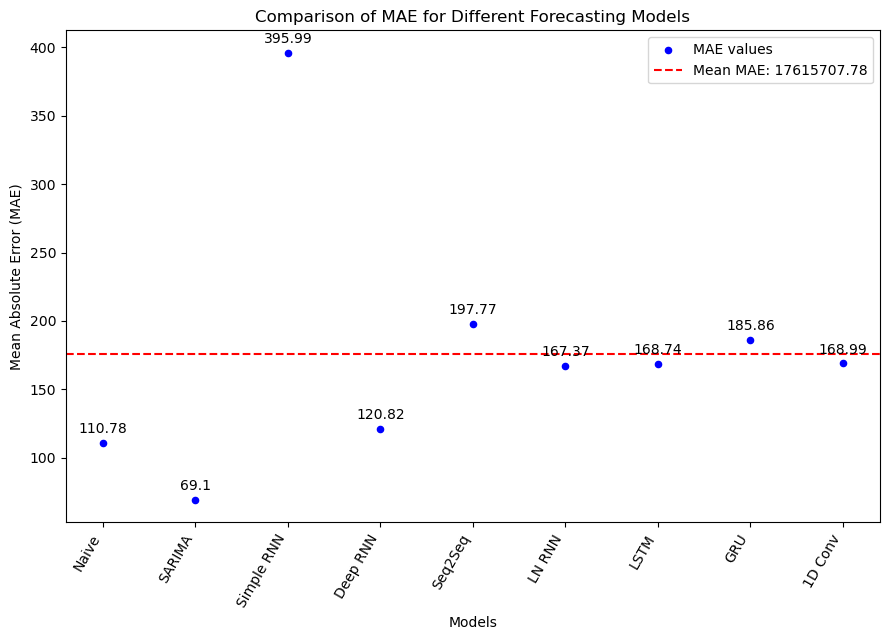

In [131]:
import matplotlib.pyplot as plt

models = ['Naive', 'SARIMA', 'Simple RNN', 'Deep RNN', 'Seq2Seq', 'LN RNN', 'LSTM', 'GRU', '1D Conv']
mae_values = [naive_mae, sarima_mae, simple_rnn_mae, deep_rnn_mae, seq2seq_mae, ln_rnn_mae, lstm_mae, gru_mae, oned_conv_mae]
mean_mae = np.mean(mae_values)

mae_values = np.array(mae_values) / 100_000

# Plotting
plt.figure(figsize=(9, 6.5))
plt.scatter(models, mae_values, color='blue', s=20, label='MAE values')
plt.axhline(y=mean_mae / 100_000, color='r', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE for Different Forecasting Models')
plt.xticks(rotation=60, ha='right')

for model, mae in zip(models, mae_values):
    plt.text(model, mae + 5, round(mae, 2), ha='center', va='bottom') 

plt.legend()
plt.tight_layout()
plt.show()